In [1]:
import pandas as pd
import logomaker as lm
import seaborn as sns
import matplotlib.pyplot as plt
train_bench=pd.read_csv("train_bench.tsv", sep="\t")
train_bench
print("Number of OrganismName unique values: ",train_bench["OrganismName"].nunique())


Number of OrganismName unique values:  435


In [2]:
#Recover the ten most frequent OrganismName to make the unique value number of OrganismName field comparable to Kingdom field unique value number
tmp_var=train_bench.groupby('OrganismName').nunique().sort_values(by='EntryID', ascending=False).head(6).reset_index()
tmp_most_rep=tmp_var['OrganismName'].tolist()
train_bench.loc[~train_bench["OrganismName"].isin(tmp_most_rep), "OrganismName"] = "Other"
print("Number of OrganismName unique values: ",train_bench["OrganismName"].nunique())

Number of OrganismName unique values:  7


## Pie Plot and Bar Plots of Taxonomic classification

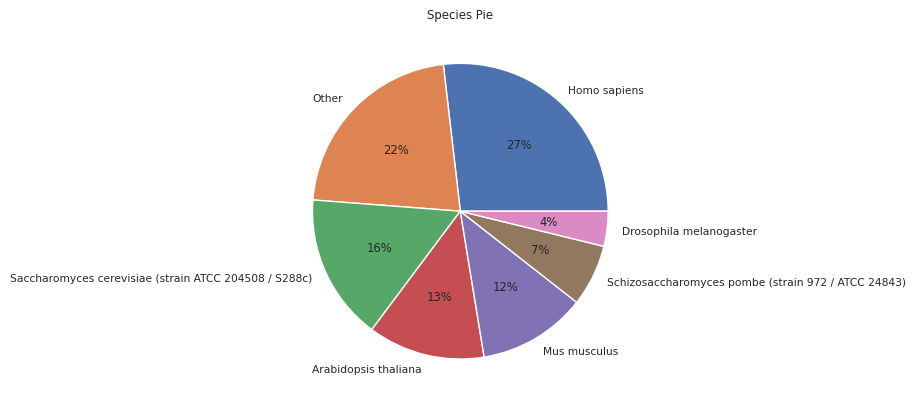

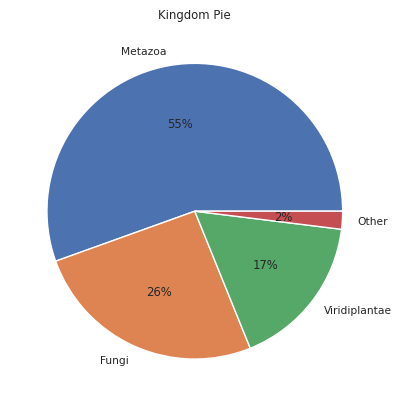

Text(0.5, 0.98, 'Kingdom Barplot')

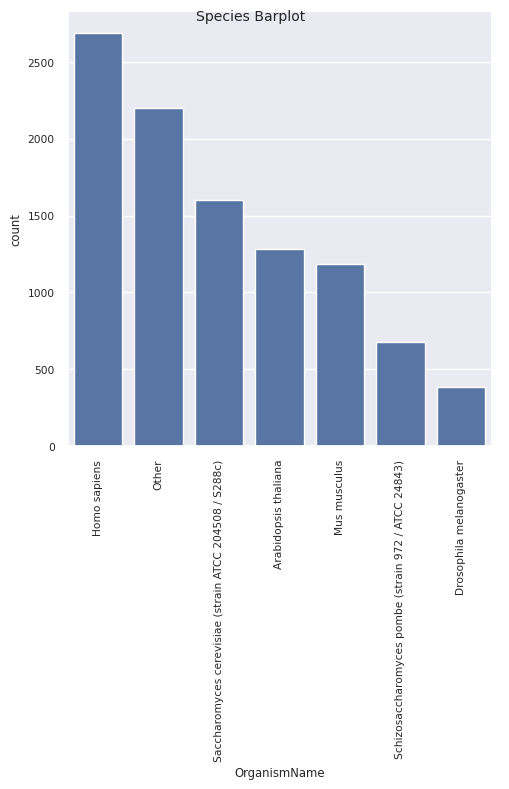

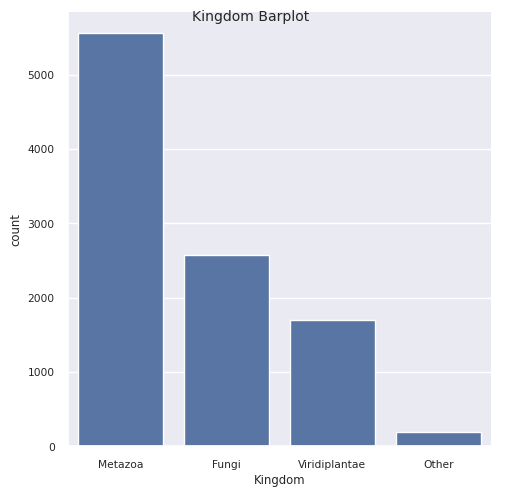

In [3]:

#Create the pie plot with respect of OrganismName
sns.set_theme(context='notebook', style='darkgrid', palette='deep',font='sans-serif', font_scale=0.7,color_codes=True,rc=None)
counts_organismname=train_bench['OrganismName'].value_counts()
plt.pie(counts_organismname, labels=counts_organismname.index,autopct='%1.0f%%')
plt.title("Species Pie")
plt.show()

#Create the pie plot with respect of Kingdom
counts_kingdom=train_bench['Kingdom'].value_counts()
plt.pie(counts_kingdom, labels=counts_kingdom.index,autopct='%1.0f%%')
plt.title("Kingdom Pie")
plt.show()

#Create the barplot with respect of OrganismName
counts_organismname=counts_organismname.to_frame(name="count")
sns.catplot(counts_organismname, x="OrganismName",y="count", kind='bar').set_xticklabels(rotation=90).fig.suptitle("Species Barplot")   


#Create the barplot with respect of Kingdom
counts_kingdom=counts_kingdom.to_frame(name="count")
sns.catplot(counts_kingdom, x="Kingdom",y="count", kind='bar').fig.suptitle("Kingdom Barplot")

## SeqLogo of benchmark sequences

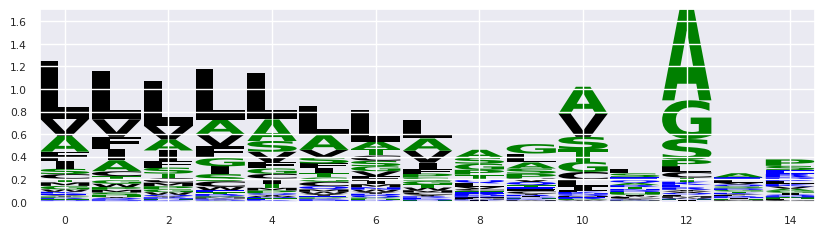

In [12]:
#We need to select the positive and benchmark sequences from the original dataframe
bench_pos=train_bench.query('Class=="Positive" and Set=="Benchmark"')
#you have to recover the region -12 and +3 after cleavage site
bench_seqs=[]
for index,row in bench_pos.iterrows():
        sequence_to_recover=row["Sequence"]
        cleavage_position=int(row["SPEnd"])
        bench_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+2])

# Information matrix used to construct the sequence logo
ww_counts_df = lm.alignment_to_matrix(sequences=bench_seqs, to_type='information',characters_to_ignore='.-X') #create a matrix that will be used to build the logo, with the frequencies of the aminoacid in that position

#draw the sequence logo
lm.Logo(ww_counts_df,color_scheme="hydrophobicity")
plt.savefig("sequence_logo_benchmark.png", dpi=300, bbox_inches="tight")

## SeqLogo of training sequences

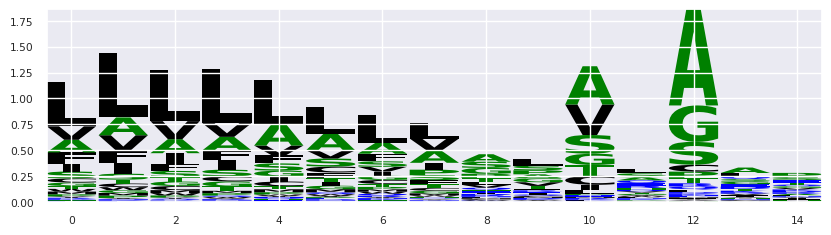

In [15]:
#We need to select the positive and training sequences from the original dataframe
train_pos=train_bench.query('Class=="Positive" and (Set=="1" or Set=="2" or Set=="3" or Set=="4" or Set=="5")')
train_seqs=[]
#you have to recover -12 from SPend and +3 after SPend
for index,row in train_pos.iterrows():
        sequence_to_recover=row["Sequence"]
        cleavage_position=int(row["SPEnd"])
        train_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+2])
    
# Information matrix used to construct the sequence logo
ww_counts_df = lm.alignment_to_matrix(sequences=train_seqs, to_type='information',characters_to_ignore='.-X') #create a matrix that will be used to build the logo, with the frequencies of the aminoacid in that position

#draw the sequence logo
logo=lm.Logo(ww_counts_df,color_scheme="hydrophobicity")
plt.savefig("sequence_logo_training.png", dpi=300, bbox_inches="tight")
